# Load & process data

In [15]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx 
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
import json
from src import evaluation_functions as ef
from src import matching_functions as mf
from src import simplification_functions_new as sf

**Load settings for analysis:**

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    use_custom_filter = parsed_yaml_file['use_custom_filter']
    custom_filter = parsed_yaml_file['custom_filter']
    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    osm_cycling_infrastructure_type = parsed_yaml_file['osm_cycling_infrastructure_type']
    osm_way_tags = parsed_yaml_file['osm_way_tags']

    reference_comparison = parsed_yaml_file['reference_comparison']
    reference_fp = parsed_yaml_file['reference_fp']
    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    ref_cycling_infrastructure_type = parsed_yaml_file['ref_cycling_infrastructure_type']
    reference_id_col = parsed_yaml_file['reference_id_col']

    grid_cell_size = parsed_yaml_file['grid_cell_size']

    
print('Settings loaded!')

ef.check_settings_validity(study_area, study_area_poly_fp, study_crs, use_custom_filter, custom_filter, reference_comparison,
    reference_fp, reference_geometries, cycling_bidirectional, grid_cell_size)


Settings loaded!


## Load data defining study area

The size of the study area is 181.38 square kilometers


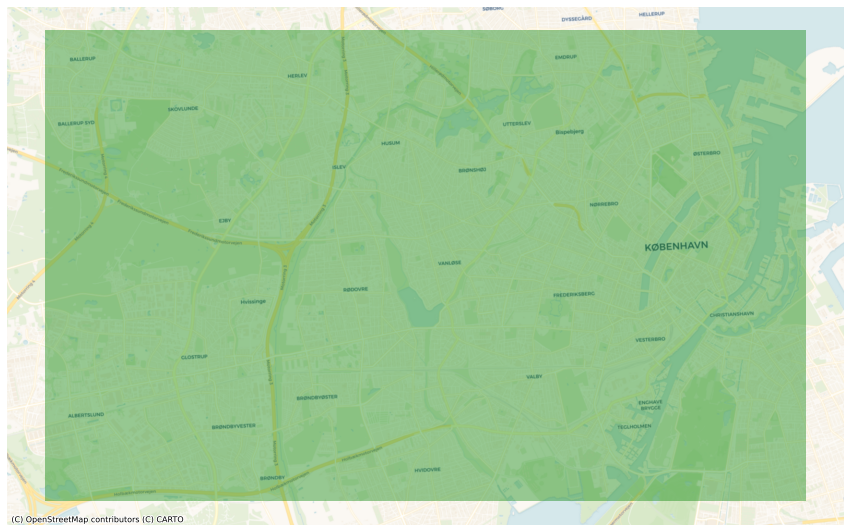

In [3]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print('Please assign a crs to the study area polygon!')

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f'The size of the study area is {area / 1000000:.2f} square kilometers')

fig, ax = plt.subplots(1, figsize=(15,15))

study_area_poly.plot(ax=ax, color='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

### Create grid to be used in the analysis

/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


The grid contains 770 cells


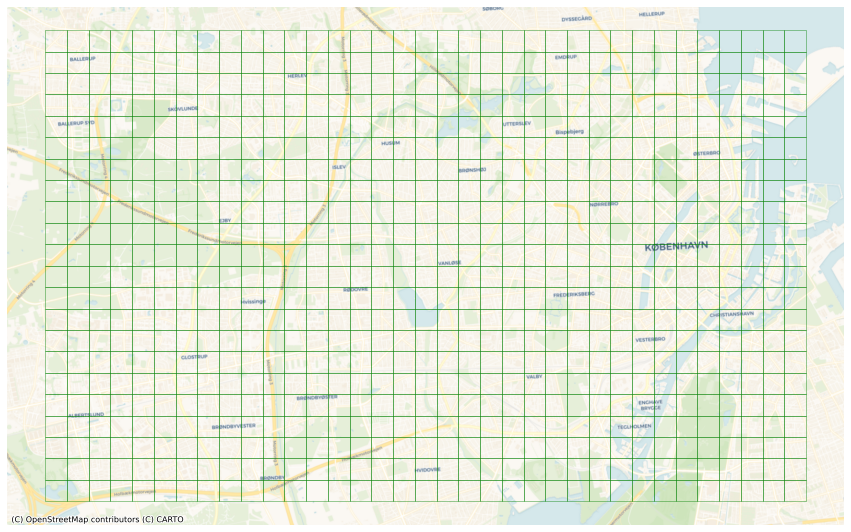

In [4]:
grid = ef.create_grid_geometry(study_area_poly, grid_cell_size)

grid['grid_id'] = grid.index

grid.to_file(f'../data/grid_{study_area}.gpkg')

fig, ax = plt.subplots(1, figsize=(15,15))

print(f'The grid contains {len(grid)} cells')

grid.plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

## Load OSM data

In this step we:
- Download data from OpenStreetMap using OSMnx
- Project the data to the chosen CRS
- Create a subnetwork consisting only of cycling infrastructure is created
- Classify all edges in the cycling network based on whether they are protected or unprotected cycling infrastructure, how they have been digitised, and whether they allow for bidirectional travel or not
- Simplify the network *(to read more about the modified OSMnx simplification (Boeing, 2017) used here, we refer to this [Github repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration)*

Depending on the size of your study area, getting data through OSMnx can take a little while.

In [5]:
# TODO: Use other method for getting graph based on custom filter?

ox.utils.config(use_cache=False, 
    useful_tags_way = osm_way_tags)

graph_osm = ox.graph_from_polygon(study_area_poly.to_crs('EPSG:4326').loc[0, 'geometry'], network_type='bike', simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=True)

print('Data retrieved!')

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = mf.clean_col_names(osm_edges)
osm_nodes = mf.clean_col_names(osm_nodes)

# Add attribute on whether cycling infra exist or not (to be used by e.g. simplification function)
osm_edges['cycling_infrastructure'] = 'no'


for q in cycling_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)

    osm_edges.loc[ox_filtered.index, 'cycling_infrastructure'] = 'yes'

osm_edges.cycling_infrastructure.value_counts()

# Overview of data from OSM
graph_area = ef.get_graph_area(osm_nodes, study_area_poly, study_crs)
print(f'The graph covers an area of {graph_area/ 1000000:.2f} square kilometers')

# Define whether cycling infrastructure is in both or one direction and whether it is one- or bidirectional
osm_edges = ef.simplify_cycling_tags(osm_edges)

# Measure the length of cycling infrastructure (!=from length of edges)
osm_edges['infrastructure_length'] = osm_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

cycling_edges = osm_edges.loc[osm_edges.cycling_infrastructure == 'yes'].copy()

# Classify edges as protected or unprotected
cycling_edges = ef.define_protected_unprotected(cycling_edges, osm_cycling_infrastructure_type)

cycling_graph, cycling_nodes = ef.create_cycling_network(cycling_edges, osm_nodes, graph_osm, return_nodes=True)
print('Created network only with cycling infrastructure!')

# Simplify cycling network
cycling_graph_simplified = sf.momepy_simplify_graph(cycling_graph, attributes=['cycling_infrastructure','cycling_bidirectional','cycling_geometries','protected'])

# Get undirected network representation
cycling_graph_simplified_un = ox.get_undirected(cycling_graph_simplified)
cycling_graph_un = ox.get_undirected(cycling_graph)

# Get simple network representation
# cycling_graph_simple_true, debug_dict_simple = sf.multidigraph_to_graph(cycling_graph_simplified_un, verbose=True, debug=True)
# cycling_graph_true, debug_dict = sf.multidigraph_to_graph(cycling_graph_un, verbose=True, debug=True)

cycling_edges_undirected = ox.graph_to_gdfs(cycling_graph_un, nodes=False)
print(f'The length of the OSM network with cycling infrastructure is {cycling_edges_undirected.infrastructure_length.sum()/1000 :.2f} kilometers')

Data retrieved!
The graph covers an area of 180.18 square kilometers
Bidirectional Value Counts: 
 False    37895
True     17460
Name: cycling_bidirectional, dtype: int64
Geometry Type Value Counts: 
 true_geometries    29873
centerline         25482
Name: cycling_geometries, dtype: int64
Protected Value Counts: 
 protected      44737
unprotected     3784
mixed            610
Name: protected, dtype: int64
Created network only with cycling infrastructure!
The length of the OSM network with cycling infrastructure is 1060.89 kilometers


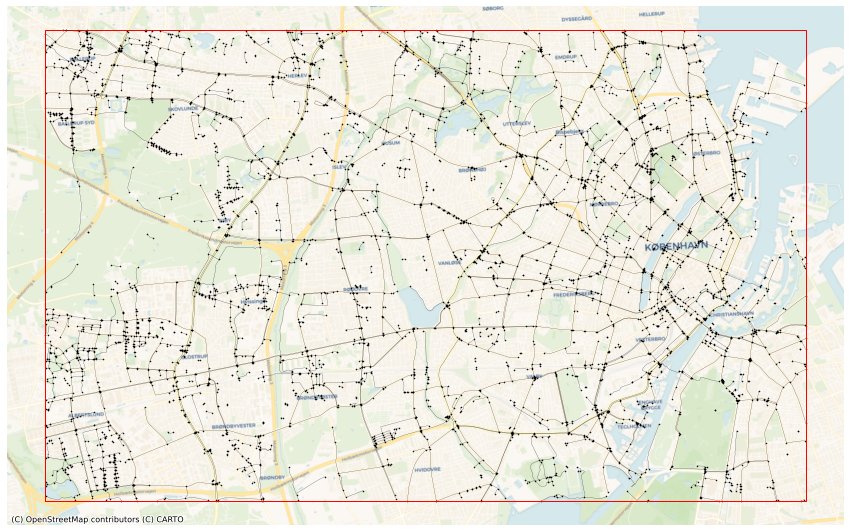

In [7]:
# Plot network
simplified_nodes, simplified_edges = ox.graph_to_gdfs(cycling_graph_simplified_un)
fig, ax = plt.subplots(1, figsize=(15,15))

simplified_edges.plot(ax=ax, color='black', linewidth=0.2)
simplified_nodes.plot(ax=ax, color='black', markersize=0.3)

study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

cx.add_basemap(
    ax=ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager
)
ax.set_axis_off()

In [8]:
# Save data
ox.save_graphml(cycling_graph_un, f'../data/osm_{study_area}.graphml')
ox.save_graphml(cycling_graph_simplified_un, f'../data/osm_{study_area}_simple.graphml')
print('OSM networks saved!')

data_load_dict = {}

# Save time for when OSM data was loaded
current_time = datetime.now().strftime('%m/%d/%Y, %H:%M:%S')
data_load_dict['data_retrieved_at'] = current_time

# Save results of simplifying network
data_load_dict['nodes_removed_during_simplification'] = len(cycling_nodes) - len(simplified_nodes)
data_load_dict['edges_removed_during_simplification'] = len(cycling_edges) - len(simplified_edges)

with open(f'../data/osm_meta_{study_area}.json', 'w') as outfile:
    json.dump(data_load_dict, outfile)


OSM networks saved!


## Load reference data

In this step we:
- Create a network from the reference data
- Project it to the chosen CRS
- Clip the data to the polygon defning the study area
- Measure the infrastructure length the edges based on the geometry type and whether they allow for bidirectional travel or not
- Simplify the network

The reference data covers an area of 169.76 square kilometers
The length of the reference network is 626.48 kilometers
Protected Value Counts: 
 protected      8438
unprotected    2130
Name: protected, dtype: int64
Reference networks saved!


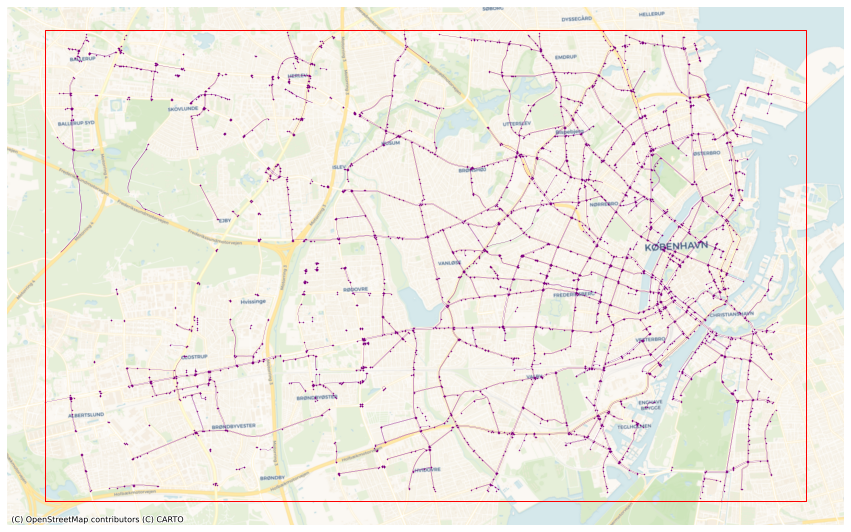

In [9]:
if reference_comparison:

    # Read reference data
    ref_data = gpd.read_file(reference_fp)

    # Create column with id called 'osmid'
    ref_data['osmid'] = ref_data[reference_id_col]

    # Reproject
    if ref_data.crs == None:
        print('Please assign a crs to the study area polygon!')

    if ref_data.crs != study_crs:
        ref_data = ref_data.to_crs(study_crs)

    assert ref_data.crs == study_crs

    # Clip reference data to study area poly
    ref_data = ref_data.clip(study_area_poly)

    # Convert to osmnx graph object
    graph_ref = mf.create_osmnx_graph(ref_data)

    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

    # Overview of data
    graph_area = ef.get_graph_area(ref_nodes, study_area_poly, study_crs)
    print(f'The reference data covers an area of {graph_area / 1000000:.2f} square kilometers')

    # Measure the length of cycling infrastructure (!=from length of edges)
    if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

        
    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

       
    elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
        
    else:
        print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')
    
    print(f'The length of the reference network is {ref_edges.infrastructure_length.sum()/1000 :.2f} kilometers')

    # Classify edges as protected or unprotected
    ref_edges = ef.define_protected_unprotected(ref_edges, ref_cycling_infrastructure_type)

    # Recreate graph with updated data
    graph_ref = mf.create_osmnx_graph(ref_edges)

    # Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of cycling infrastructure types
    graph_ref_simple = sf.momepy_simplify_graph(graph_ref, attributes=['vejklasse','protected'])

    ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(graph_ref_simple)

    # Plot network
    fig, ax = plt.subplots(1, figsize=(15,15))

    ref_simplified_edges.plot(ax=ax, color='purple', linewidth=0.2)
    ref_simplified_nodes.plot(ax=ax, color='purple', markersize=0.2)

    study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

    ax.set_axis_off()

    cx.add_basemap(
        ax, 
        crs=study_area_poly.crs, 
        source=cx.providers.CartoDB.Voyager
    )

    # Save data
    ox.save_graphml(graph_ref, f'../data/ref_{study_area}.graphml')

    ox.save_graphml(graph_ref_simple, f'../data/ref_{study_area}_simple.graphml')

    print('Reference networks saved!')

    data_load_dict = {}

    # Save results of simplifying network
    data_load_dict['nodes_removed_during_simplification'] = len(ref_nodes) - len(ref_simplified_nodes)
    data_load_dict['edges_removed_during_simplification'] = len(ref_edges) - len(ref_simplified_edges)

    with open(f'../data/reference_meta_{study_area}.json', 'w') as outfile:
        json.dump(data_load_dict, outfile)

else:
    print('The analysis will not make use of a reference data set. Please update config settings if a extrinsic analysis of OSM data quality should be performed.')